## Hierarchical methods

We have two different types of hierarchical methods:
- agglomerative,
- divisive.

Both methods base on dendrograms, a structure that looks like a tree, dividing or merging the cluster at each level. The agglomerative method merge clusters until we get one cluster with all objects. The divisive method divide one cluster into two at each stage. We end if we get clusters where each consits of one object only.

## Libraries and functions

For implementing both methods we use only two libaries are needed and one function that was used in previous notebooks.

In [1]:
import numpy as np
from math import sqrt

def calculate_distance(x,v):
    return sqrt((x[0]-v[0])**2+(x[1]-v[1])**2)

## Agglomerative clustering

We need to keep the dendrogram and the history, so we can easily draw it.

In [2]:
%store -r data_set 

distance_matrix = np.zeros((len(data_set), len(data_set)))
current_dendrograms = [] 

for iter in range(len(data_set)):
    current_dendrograms.append(data_set[iter])

Pydot enables to use graphviz to visualize a dendrogram.

In [3]:
import pydot
import math

The tree object is the root where each edge is added.

In [4]:
tree = pydot.Dot(graph_type='graph')

In agglomerative we merge two clusters together on each step:

In [5]:
def merge_elements(current_dendrograms, merged_list, i):
    if isinstance(current_dendrograms[i][0], type(np.array([]))):
        for iter in range(len(current_dendrograms[i])):
            merged_list.append(current_dendrograms[i][iter])
    else:
        merged_list.append(current_dendrograms[i])
    return merged_list

We need to set the current dendrogram level at each step:

In [6]:
def set_current_dendrogram(current_dendrograms, dendrograms_hist, i, j):
    elements = []
    hist = []
    current_hist = dendrograms_hist[-1]
    for iter in range(len(current_dendrograms)):
        if iter != i and iter !=j:
            elements.append(current_dendrograms[iter])
            hist.append(current_hist[iter])
    merged_elements = []
    merged_elements = merge_elements(current_dendrograms, merged_elements, i)
    merged_elements = merge_elements(current_dendrograms, merged_elements, j)
    elements.append(merged_elements)
    hist.append([current_hist[i],current_hist[j]])
    dendrograms_hist.append(hist)
    current_dendrograms = elements
    return current_dendrograms, dendrograms_hist

At each stage a distance matrix needs to be calculated:

In [7]:
def calculate_dendogram_distance_matrix(current_dendrograms, distance_matrix):
    distance_matrix = np.zeros((len(current_dendrograms), len(current_dendrograms)))
    for i in range(len(current_dendrograms)):
        for j in range(len(current_dendrograms)):
            distance_matrix[i, j] = calculate_distance(calculate_centroid(current_dendrograms[i]),calculate_centroid(current_dendrograms[j]))
    return distance_matrix

The code abobve needs the centroids' average:

In [8]:
def calculate_centroid(dendrogram_elements):
    if type(dendrogram_elements) is list:
        sumof=np.zeros(len(dendrogram_elements[0]))
        for iter in range(len(dendrogram_elements)):
            sumof=np.add(sumof,np.array(dendrogram_elements[iter]))
        if sumof.shape == (len(data_set[0]),len(data_set[0])):
            pass
        return np.divide(sumof*1.0, len(dendrogram_elements)*1.0)
    else:
        return dendrogram_elements

For agglomerative we take the lowest distance from the distance matrix:

In [9]:
def get_lowest_from_distance_matrix(distance_matrix):
    lowest_indexes = [0,1]
    lowest_value = distance_matrix[0,1]
    for i in range(len(distance_matrix)):
        for j in range(len(distance_matrix)):
            if i != j:
                if lowest_value > distance_matrix[i,j]:
                    lowest_value = distance_matrix[i,j]
                    lowest_indexes = [i,j]
    return lowest_indexes

Combine it together:

In [10]:
def cluster_agg(current_dendrograms, distance_matrix):
    dendrograms_hist = [list(range(len(data_set)))]
    for iter in range(len(current_dendrograms)-1):
        distance_matrix = calculate_dendogram_distance_matrix(current_dendrograms, distance_matrix)
        [i, j] = get_lowest_from_distance_matrix(distance_matrix)
        current_dendrograms, dendrograms_hist = set_current_dendrogram(current_dendrograms, dendrograms_hist, i, j)
    return dendrograms_hist

And execute it:

In [11]:
dendrogram_hist_agg = cluster_agg(current_dendrograms, distance_matrix)

We use pydot to print the dendrogram:

In [12]:
def add_edge(level, acesor):
    if acesor != level:
        new_edge = pydot.Edge(str(acesor), str(level))
        tree.add_edge(new_edge)
    if isinstance(level,list):
        add_edge(level[0],level)
        add_edge(level[1],level)
        
def show_tree_agg():
    current_list = dendrogram_hist_agg.pop()
    root = current_list.pop()
    add_edge(root,root)
    tree.write('tree_agg.png',format='png')        

Take a look at tree_agg.png if generated.

In [13]:
show_tree_agg()

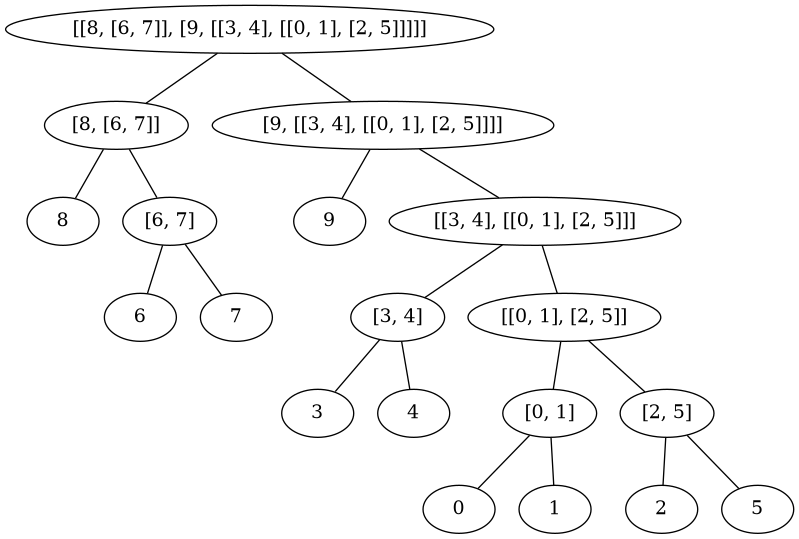

In [14]:
from IPython.display import Image
Image(filename='tree_agg.png') 

## Divisive clustering

Compared to the previous methods, we do the same, but in the opposite direction. We setup the same data, but the current dendrogram contains the whole data set as one cluster. 

In [15]:
tree = pydot.Dot(graph_type='graph')

We use a more efficient solution for the distance matrix calculation. In the following example, we calculate it once and extract the distances every time needed. This is why the below method is invoked only once.

In [16]:
def calculate_dendogram_distance_matrix_diana():
    distance_matrix=np.zeros((len(data_set), len(data_set)))
    for i in range(len(data_set)):
        for j in range(len(data_set)):
            distance_matrix[i, j] = calculate_distance(calculate_centroid(data_set[i]),calculate_centroid(data_set[j]))
    return distance_matrix

There are two new methods that needs to be implemented. The first one returns the cluster that needs to be divided:

In [17]:
def choose_cluster(current_level, distance_matrix):
    if type(current_level[0]) != list:
        both_idx = np.array(current_level)
        current = distance_matrix[both_idx[:,None], both_idx]
        diff = np.sum(current) / (current.shape[0] * current.shape[1] - len(current))
        return current_level, diff, 0
    highest_diff = 0
    cluster_id = 0
    for i in range(len(current_level)):
        both_idx = np.array(current_level[i])
        current = distance_matrix[both_idx[:, None], both_idx]
        diff = np.sum(current) / (current.shape[0] * current.shape[1]-len(current))
        if diff > highest_diff:
            highest_diff = diff
            cluster_id = i
    return current_level[cluster_id], highest_diff, cluster_id

The second method split the cluster into two clusters by counting the closest distances to each object in the cluster. Objects in both clusters are the closest ones.

In [18]:
def split(split_cluster, distance_matrix, diff):
    if len(split_cluster) == 2:
        cluster1 = [split_cluster[0]]
        cluster2 = [split_cluster[1]]
        return cluster1, cluster2
    split_threshold = diff
    both_idx = np.array(split_cluster)
    distances = distance_matrix[both_idx[:, None], both_idx]
    c1keys, c1counts = np.unique(np.argwhere(distances > split_threshold), return_counts=True)
    c2keys, c2counts = np.unique(np.argwhere(distances <= split_threshold), return_counts=True)
    cluster1_counts = dict(zip(np.array(split_cluster)[c1keys], c1counts))
    cluster2_counts = dict(zip(np.array(split_cluster)[c2keys], c2counts))
    cluster1 = []
    cluster2 = []
    choice = 0
    for item in split_cluster:
        if item not in cluster1_counts.keys():
            cluster2.append(item)
            continue
        if item not in cluster2_counts.keys():
            cluster1.append(item)
            continue
        if cluster1_counts[item] < cluster2_counts[item]:
            cluster2.append(item)
        elif cluster1_counts[item] > cluster2_counts[item]:
            cluster1.append(item)
        else:
            if choice == 0:
                cluster2.append(item)
                choice = 1
            else:
                cluster1.append(item)
                choice = 0
    return cluster1, cluster2

Combine it all together:

In [19]:
def cluster():
    dendrograms_history=[]
    current_dendrograms=[list(range(len(data_set)))]
    distance_matrix = calculate_dendogram_distance_matrix_diana()
    while len(current_dendrograms) != len(data_set):
        current_level = current_dendrograms[-1]
        current_cluster, diff, cluster_id = choose_cluster(current_level, distance_matrix)
        cluster1, cluster2 = split(current_cluster, distance_matrix, diff)
        if type(current_level[0]) != list:
            current_dendrograms.append([cluster1, cluster2])
        else:
            rest = current_level.copy()
            rest.pop(cluster_id)
            rest.append(cluster1)
            rest.append(cluster2)
            current_dendrograms.append(rest)
        hist = [{"acesor": current_cluster, "childs": [cluster1,cluster2]}]
        dendrograms_history.append(hist)
    return dendrograms_history

We get the dendrogram levels with:

In [20]:
dendrogram_hist_diana = cluster()

%store dendrogram_hist_diana

Stored 'dendrogram_hist_diana' (list)


/tmp/ipykernel_23146/3794691773.py:12: RuntimeWarning: invalid value encountered in scalar divide
  diff = np.sum(current) / (current.shape[0] * current.shape[1]-len(current))


The method that draw the dendrogram is a bit different compared to the agglomerative method:

In [21]:
def show_tree_divisive():
    for item in dendrogram_hist_diana:
        for child in item[0]["childs"]:
            new_edge = pydot.Edge(str(item[0]["acesor"]),str(child))
            tree.add_edge(new_edge)
    tree.write('tree_diana.png',format='png')

In [22]:
show_tree_divisive()

We can display the dendrogram the same as in the previous example: